In [147]:
# import sys
# from importlib import reload
# reload(sys.modules["util.plot"])

import h5py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from util.path import Path

from himalaya.scoring import correlation_score

from sklearn.linear_model import LinearRegression
from scipy.stats import zscore
from util import plot, subject

from util.atlas import Atlas
from constants import SUBS_STRANGERS, MOTION_CONFOUNDS, CONFOUND_REGRESSORS, TR, RUNS, RUN_TRIAL_SLICE, EXTRA_MOTION_CONFOUNDS

import warnings
warnings.filterwarnings("ignore")

In [2]:
%cd ..

/scratch/gpfs/zzada/fconv


# test

1. no motion
2. motion in run
3. motion in trial
3. motion in trial and split

within and between

In [173]:
cachepath = Path(
    root="data/derivatives/cleaned",
    sub="",
    datatype="func",
    task="Conv",
    space='fsaverage6',
    desc='trialmot6',
    suffix="confounds",
    ext=".npy",
)

In [192]:
cache = 'runmot'
cache = 'runmotextra'
cache = 'nomot'
cache = 'trialmot'
cache = 'trialmot6'

In [193]:
corrs = []
corrsP = []
corrsC = []
corrs2 = []
corrs2P = []
corrs2C = []

for subA in tqdm(SUBS_STRANGERS):
    _, switches = subject.get_button_presses(subA)
    prodmaskA = switches.astype(bool)
    compmaskA = ~prodmaskA

    dataA, fwd = subject.get_bold(subA, use_cache=True, cache_desc=cache, return_confounds=["framewise_displacement"])
    subB = subject.get_partner(subA)
    cachepath.update(sub=f"{subB:03d}")
    fwd2 = np.load(cachepath)

    for i in range(0, 1200, 120):
        trial_slice = slice(i, i+120)

        trial_dataA = dataA[trial_slice]
        trial_fwd = fwd[trial_slice]
        trial_fwd2 = fwd2[trial_slice]
        trial_pmask = prodmaskA[trial_slice]
        trial_cmask = compmaskA[trial_slice]

        corrs.append(correlation_score(trial_dataA, trial_fwd))
        corrsP.append(correlation_score(trial_dataA[trial_pmask], trial_fwd[trial_pmask]))
        corrsC.append(correlation_score(trial_dataA[trial_cmask], trial_fwd[trial_cmask]))
        corrs2.append(correlation_score(trial_dataA, trial_fwd2))
        corrs2P.append(correlation_score(trial_dataA[trial_pmask], trial_fwd2[trial_pmask]))
        corrs2C.append(correlation_score(trial_dataA[trial_cmask], trial_fwd2[trial_cmask]))

corrs = np.stack(corrs)
corrsP = np.stack(corrsP)
corrsC = np.stack(corrsC)
corrs2 = np.stack(corrs2)
corrs2P = np.stack(corrs2P)
corrs2C = np.stack(corrs2C)

100%|██████████| 58/58 [04:40<00:00,  4.84s/it]


In [194]:
np.nan_to_num(corrsP, copy=False)
np.nan_to_num(corrsC, copy=False)
np.nan_to_num(corrs2P, copy=False)
np.nan_to_num(corrs2C, copy=False);

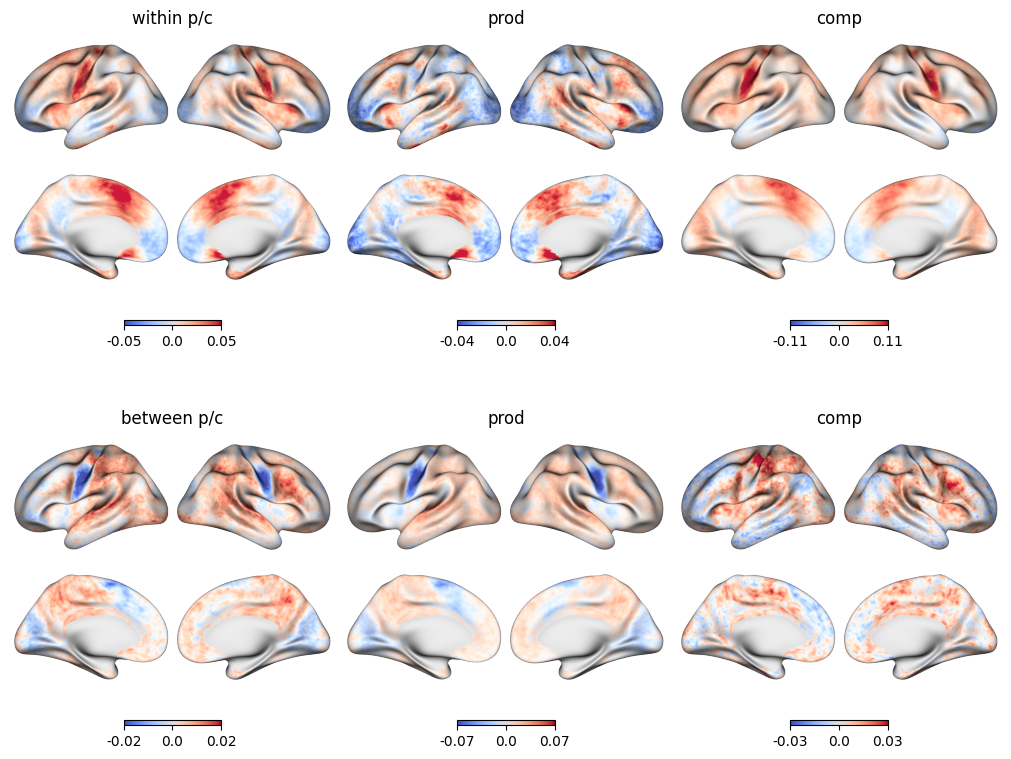

In [195]:
fig, axes = plt.subplots(2, 3, figsize=(10, 8), layout='constrained')
plot.surface_plot(corrs.mean(0), title='within p/c', fig=fig, ax=axes[0,0])
plot.surface_plot(corrsP.mean(0), title='prod', fig=fig, ax=axes[0,1])
plot.surface_plot(corrsC.mean(0), title='comp', fig=fig, ax=axes[0,2])
plot.surface_plot(corrs2.mean(0), title='between p/c', fig=fig, ax=axes[1,0])
plot.surface_plot(corrs2P.mean(0), title='prod', fig=fig, ax=axes[1,1])
plot.surface_plot(corrs2C.mean(0), title='comp', fig=fig, ax=axes[1,2])
# fig.suptitle('nomot')
fig.show()

# get bold function

In [155]:
subA = 104
space = 'fsaverage6'
cache_desc = 'nomot'

run_confounds = CONFOUND_REGRESSORS #+ MOTION_CONFOUNDS + ['framewise_displacement']
trial_confounds = MOTION_CONFOUNDS + EXTRA_MOTION_CONFOUNDS[:-1] # + ['framewise_displacement']
return_confounds = ['framewise_displacement'] # , 'dvars']

In [156]:
cachepath = Path(
    root="data/derivatives/cleaned",
    sub=f"{subA:03d}",
    datatype="func",
    task="Conv",
    space=space,
    desc=cache_desc,
    suffix="bold",
    ext=".npy",
)

# load brain data
is_surface = space.startswith("fsaverage")
boldpath = Path(
    root="data/derivatives/fmriprep",
    sub=f"{subA:03d}",
    ses="1",
    datatype="func",
    task="Conv",
    run=1,
    space=space,
    desc=None if is_surface else "preproc",
    hemi="L" if is_surface else None,
    suffix="bold",
    ext=".func.gii" if is_surface else ".nii.gz",
)


In [157]:
# Set up masker
if space.startswith("fsaverage"):
    masker = subject.GiftiMasker(
        t_r=TR,
        ensure_finite=True,
        standardize='zscore_sample',
        standardize_confounds=True,
    )

rt_dict = subject.get_trials(subA)
_, switches = subject.get_button_presses(subA)
prod_mask = switches.astype(bool)
reg_model = LinearRegression()

In [158]:
# reg_model = LinearRegression()

# Get the brain data per run, also removes confounds and applies
bold_trials = []
conf_trials = []
pmasks = []
for run in RUNS:
    boldpath = boldpath.update(run=run)
    confoundpath = boldpath.copy()
    del confoundpath["space"]
    if is_surface:
        del confoundpath["hemi"]
    confoundpath.update(desc="confounds", suffix="timeseries", ext=".tsv")

    conf_data = None
    if run_confounds is not None and len(run_confounds):
        conf_data = pd.read_csv(confoundpath, sep="\t", usecols=run_confounds)
        conf_data.fillna(value=0, inplace=True)
        conf_data = conf_data.to_numpy()

    conf_motion = None
    if trial_confounds is not None and len(trial_confounds):
        conf_motion = pd.read_csv(confoundpath, sep="\t", usecols=trial_confounds)
        conf_motion.fillna(value=0, inplace=True)
        conf_motion = conf_motion.to_numpy()

    conf_ret = None
    if return_confounds is not None and len(return_confounds):
        conf_ret = pd.read_csv(
            confoundpath,
            sep="\t",
            usecols=return_confounds,
        ).to_numpy()

    boldpaths = boldpath
    if is_surface:
        boldpaths = [boldpath, boldpath.copy().update(hemi="R")]

    # Extract the BOLD data
    # with warnings.catch_warnings():
    #     warnings.simplefilter(action="ignore", category=FutureWarning)
    bold = masker.fit_transform(
        boldpaths,  # type: ignore
        confounds=conf_data,
    )

    # Mask for the two trials for this run that are generate condition
    use_trials = rt_dict[run]
    for j, trial in enumerate(use_trials):
        # get bold data
        trial_slice = RUN_TRIAL_SLICE[trial]
        bold_trial = bold[trial_slice]

        if conf_motion is not None:
            # select the relevant part from the mask
            start = (run - 1) * 240 + (j * 120)  # TODO this is right?
            trial_pmask = prod_mask[start : start + 120]
            pmasks.append(trial_pmask)
            print(start, start+120, trial_slice)

            # conf_trial2 = conf_motion[trial_slice]

            # split motion confounds into prod/comp
            conf_trial = zscore(conf_motion[trial_slice], axis=0)
            conf_trial = np.nan_to_num(conf_trial, copy=False)
            n_motconfs = conf_motion.shape[1]
            conf_trial2 = np.zeros((120, n_motconfs * 2 + 2))
            conf_trial2[trial_pmask, :n_motconfs] = conf_trial[trial_pmask]
            conf_trial2[~trial_pmask, n_motconfs:-2] = conf_trial[~trial_pmask]
            conf_trial2[:, -2] = trial_pmask.astype(conf_trial2.dtype)
            conf_trial2[:, -1] = (~trial_pmask).astype(conf_trial2.dtype)

            # get residual
            reg_model = reg_model.fit(conf_trial2, bold_trial)
            bold_trial -= reg_model.predict(conf_trial2)

        bold_trials.append(zscore(bold_trial, axis=0))
        if conf_ret is not None:
            conf_trials.append(conf_ret[trial_slice])

    break

all_bold = np.vstack(bold_trials)
all_bold = np.nan_to_num(all_bold, copy=False)
print(all_bold.shape)

all_conf = np.vstack(conf_trials)
print(all_conf.shape)

0 120 slice(14, 134, None)
120 240 slice(416, 536, None)
(240, 81924)
(240, 1)


In [162]:
len(trial_confounds)

24

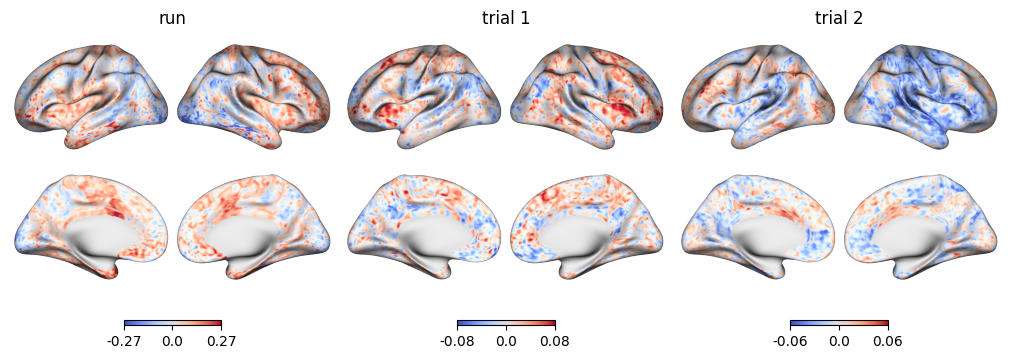

In [160]:
valuesRun = correlation_score(bold, conf_ret)  # run level
valuesT1 = correlation_score(all_bold[:120], all_conf[:120])
valuesT2 = correlation_score(all_bold[120:], all_conf[120:])

fig, axes = plt.subplots(1, 3, figsize=(10, 4), layout='constrained')
plot.surface_plot(valuesRun, title='run', fig=fig, ax=axes[0])
plot.surface_plot(valuesT1, title='trial 1', fig=fig, ax=axes[1])
plot.surface_plot(valuesT2, title='trial 2', fig=fig, ax=axes[2])
fig.show()

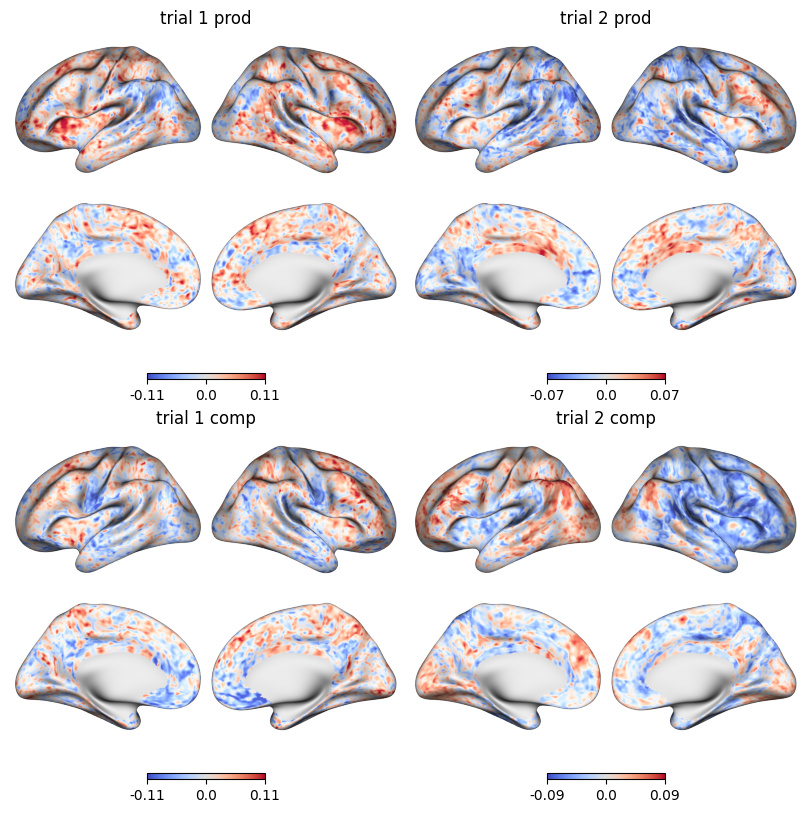

In [161]:
valuesT1P = correlation_score(all_bold[:120][pmasks[0]], all_conf[:120][pmasks[0]])
valuesT1C = correlation_score(all_bold[:120][~pmasks[0]], all_conf[:120][~pmasks[0]])
valuesT2P = correlation_score(all_bold[120:][pmasks[1]], all_conf[120:][pmasks[1]])
valuesT2C = correlation_score(all_bold[120:][~pmasks[1]], all_conf[120:][~pmasks[1]])

fig, axes = plt.subplots(2, 2, figsize=(8, 8), layout='constrained')
plot.surface_plot(valuesT1P, title='trial 1 prod', fig=fig, ax=axes[0,0])
plot.surface_plot(valuesT2P, title='trial 2 prod', fig=fig, ax=axes[0,1])
plot.surface_plot(valuesT1C, title='trial 1 comp', fig=fig, ax=axes[1,0])
plot.surface_plot(valuesT2C, title='trial 2 comp', fig=fig, ax=axes[1,1])
fig.show()

In [93]:
bold = masker.fit_transform(
    boldpaths,  # type: ignore
    confounds=conf_data,
)
bold.shape, conf_data.shape,conf_ret.shape

((544, 81924), (544, 16), (544, 1))

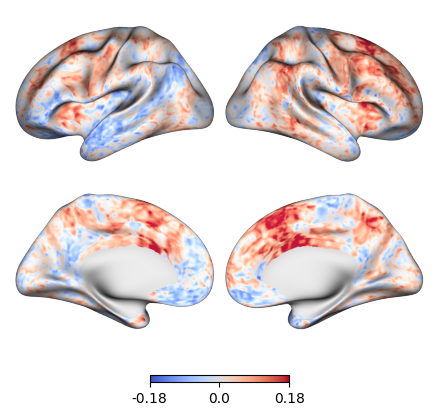

In [94]:
values = correlation_score(bold, conf_ret)
plot.surface_plot(values);

In [95]:
rt_dict

{1: [1, 4], 2: [2, 3], 3: [2, 3], 4: [1, 4], 5: [2, 3]}

In [103]:
slice = RUN_TRIAL_SLICE[3]
slice

slice(282, 402, None)

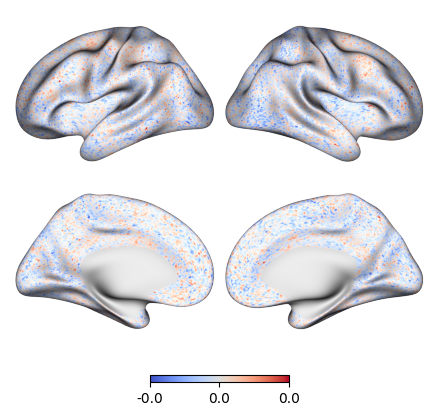

In [105]:
# values = correlation_score(all_bold[slice], all_conf[slice])
values = correlation_score(all_bold, all_conf)
plot.surface_plot(values);